Created by: 

Date: 2024-12-11

Latest change when and what:

Notes:

# 3. Model selection

Trying different models, from baseline to advanced and comparing their outcomes.

In [1]:
# importing packages
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


In [ ]:
# loading train, test and validation datasets - lowercase!

# reloading the datasets
train_data = pd.read_csv("../2_preprocessing/train_lowercase.csv")
test_data = pd.read_csv("../2_preprocessing/test_lowercase.csv")
val_data = pd.read_csv('../2_preprocessing/validation_lowercase.csv')

In [5]:
average_characters = train_data['script'].apply(len).mean()
average_characters = round(average_characters,0)

print(f"Average number of characters: {average_characters}")

Average number of characters: 123895.0


## 3.1 Bag of Words (BoW)

.fit_transform uses the input to create the frequency matrix of words.
.transform counts the words in the input using the frequency matrix already created with the training data
so if a word is not present in the frequency matrix created with the training data, it is lost

In [155]:
# creating frequency matrix using the training data and transforming the validation data set

# train data 
texts_train = train_data["script"].to_list()
y_train = train_data.passed_bechdel.to_list()

# create frequency matrix of words
vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(texts_train) # only for training!

# validation data 
texts_val = val_data["script"].to_list()
y_val = val_data.passed_bechdel.to_list()

# plot the words in the validation dataset in the matrix made on the training data 
features_val = vectorizer.transform(texts_val) # notice - only transform, not fitting

In [ ]:
# sanity check
print(features_train.shape)
print(len(vectorizer.vocabulary_))
vectorizer.vocabulary_

In [157]:
#initializing model
#clf = LogisticRegression(random_state=42, solver = 'saga', max_iter = 200).fit(features_train, y_train) # update the weights of the model using the training data
clf_log_reg = LogisticRegression(random_state=42).fit(features_train, y_train)

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [164]:
# save performance metrics to be used for plotting later
performances = []

for x, y, nsplit in zip([features_train, features_val],
                        [y_train, y_val],
                        ['train', 'val']):
    mean_accuracy_score = clf_log_reg.score(x, y) # mean across default max 100 iterations
    preds = clf_log_reg.predict(x)
    f1 = f1_score(y, preds)

    performances.append({'model': 'BoW_log_reg',
                        'split': nsplit,
                        'mean_acc_score': round(mean_accuracy_score,4),
                        'f1_score': round(f1,4)})

performances

[{'model': 'BoW_log_reg',
  'split': 'train',
  'mean_acc_score': 0.9972,
  'f1_score': 0.9972},
 {'model': 'BoW_log_reg',
  'split': 'val',
  'mean_acc_score': 0.6742,
  'f1_score': 0.6778}]

In [165]:
# adding random forest
clf_forest = RandomForestClassifier(random_state=42).fit(features_train, y_train)

for x, y, nsplit in zip([features_train, features_val],
                        [y_train, y_val],
                        ['train', 'val']):
    mean_accuracy_score = clf_forest.score(x, y) # mean across default max 100 iterations
    preds = clf_forest.predict(x)
    f1 = f1_score(y, preds)

    performances.append({'model': 'BoW_rf',
                        'split': nsplit,
                        'mean_acc_score': round(mean_accuracy_score,4),
                        'f1_score': round(f1,4)})



In [167]:
from sklearn.svm import SVC

In [ ]:
# support vector maching
clf_svm = SVC(random_state = 42, max_iter=500).fit(features_train, y_train)

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [169]:
for x, y, nsplit in zip([features_train, features_val],
                        [y_train, y_val],
                        ['train', 'val']):
    mean_accuracy_score = clf_svm.score(x, y) 
    preds = clf_svm.predict(x)
    f1 = f1_score(y, preds)

    performances.append({'model': 'BoW_svm',
                        'split': nsplit,
                        'mean_acc_score': round(mean_accuracy_score,4),
                        'f1_score': round(f1,4)})

In [170]:
performances

[{'model': 'BoW_log_reg',
  'split': 'train',
  'mean_acc_score': 0.9972,
  'f1_score': 0.9972},
 {'model': 'BoW_log_reg',
  'split': 'val',
  'mean_acc_score': 0.6742,
  'f1_score': 0.6778},
 {'model': 'BoW_rf',
  'split': 'train',
  'mean_acc_score': 0.9979,
  'f1_score': 0.9979},
 {'model': 'BoW_rf',
  'split': 'val',
  'mean_acc_score': 0.6798,
  'f1_score': 0.6851},
 {'model': 'BoW_svm',
  'split': 'train',
  'mean_acc_score': 0.8399,
  'f1_score': 0.8364},
 {'model': 'BoW_svm',
  'split': 'val',
  'mean_acc_score': 0.736,
  'f1_score': 0.7283}]

In [ ]:
# plot distinct words in each label based on frequencies 

# fix variable names
X = features_train.copy()
labels = train_data['passed_bechdel']

# Get the vocabulary mapping (word to column index)
vocabulary = vectorizer.vocabulary_
words = np.array(list(vocabulary.keys()))
word_indices = np.array(list(vocabulary.values()))

# Separate the word frequencies by label
X_label_0 = X[labels == 0].toarray().sum(axis=0)  # Word frequencies for label 0
X_label_1 = X[labels == 1].toarray().sum(axis=0)  # Word frequencies for label 1

# Calculate the difference in frequencies between label 1 and label 0
frequency_diff = X_label_1 - X_label_0

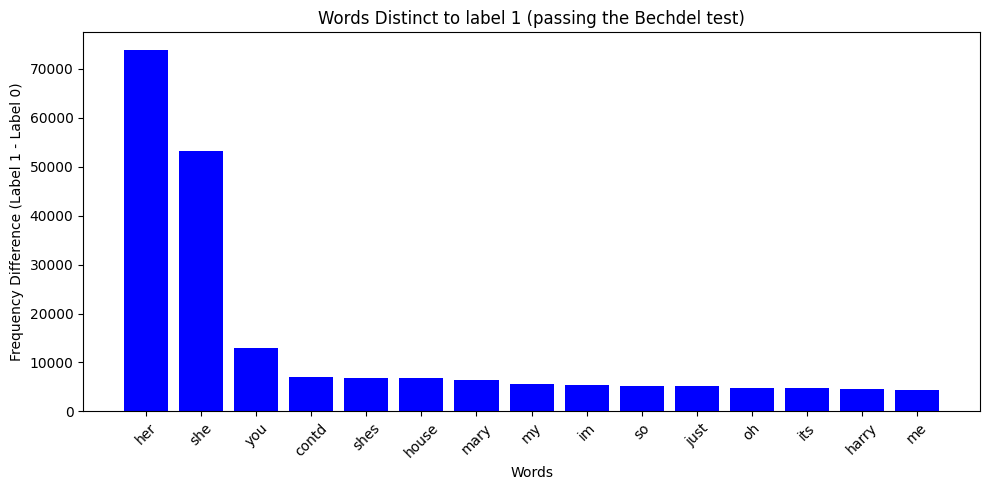

In [64]:
# Find the top 10 words distinct to label 1
top_indices_distinct_label_1 = np.argsort(frequency_diff)[-15:][::-1]  # Largest positive differences
distinct_words_label_1 = filtered_words[top_indices_distinct_label_1]
distinct_frequencies_label_1 = frequency_diff[top_indices_distinct_label_1]

# Plot the distinct words for label 1
plt.figure(figsize=(10, 5))
plt.bar(distinct_words_label_1, distinct_frequencies_label_1, color='blue')
plt.title("Words Distinct to label 1 (passing the Bechdel test)")
plt.xlabel("Words")
plt.ylabel("Frequency Difference (Label 1 - Label 0)")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('../figures/BoW_words_label1.jpeg', format='jpeg', dpi=300) 

plt.show()

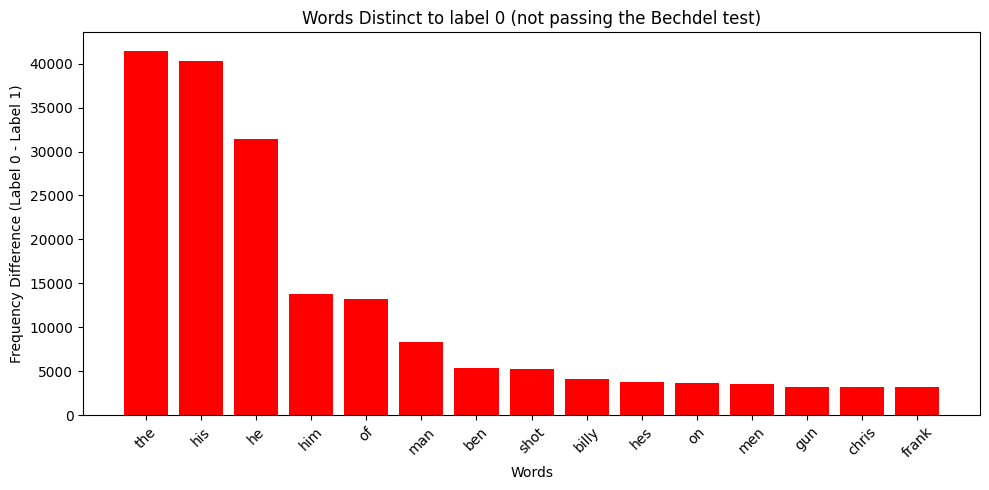

In [65]:
# Find the top 10 words distinct to label 0
top_indices_distinct_label_0 = np.argsort(filtered_frequency_diff)[:15]  # Largest negative differences
distinct_words_label_0 = filtered_words[top_indices_distinct_label_0]
distinct_frequencies_label_0 = filtered_frequency_diff[top_indices_distinct_label_0]

# Plot the distinct words for label 0
plt.figure(figsize=(10, 5))
plt.bar(distinct_words_label_0, -distinct_frequencies_label_0, color='red')  # Flip sign for better visualization
plt.title("Words Distinct to label 0 (not passing the Bechdel test)")
plt.xlabel("Words")
plt.ylabel("Frequency Difference (Label 0 - Label 1)")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('../figures/BoW_words_label0.jpeg', format='jpeg', dpi=300) 

plt.show()


In [ ]:
### make wordclouds here xx

## 3.2 TF-IDF

checkout class4 to see how to use this with a neural logistric regression classifier xx

In [171]:
vectorizer = TfidfVectorizer()

features_train = vectorizer.fit_transform(texts_train)
features_val = vectorizer.transform(texts_val)

In [100]:
# sanity checking
print(features_train.shape)
vectorizer.vocabulary_

(1424, 336748)


{'sony': 69695,
 'pictures': 57002,
 'classics': 17459,
 'presents': 58755,
 'in': 39667,
 'association': 8902,
 'with': 83415,
 'gravier': 34235,
 'productions': 59109,
 'perdido': 56412,
 'production': 59108,
 'blue': 12458,
 'jasmine': 41748,
 'written': 84034,
 'and': 7254,
 'directed': 23641,
 'by': 14529,
 'woody': 83692,
 'allen': 6675,
 'rated': 60845,
 'pg13': 56732,
 '98': 4466,
 'minutes': 49256,
 'release': 61885,
 'date': 21826,
 '07262013': 88,
 'nyla': 52943,
 'east': 25846,
 'coast': 17948,
 'publicity': 59571,
 '42west': 2986,
 'scott': 65493,
 'feinstein': 29405,
 '220': 1966,
 'west': 82402,
 '42nd': 2985,
 'street': 71929,
 '12th': 718,
 'floor': 30566,
 'new': 51674,
 'york': 84697,
 'ny': 52935,
 '10036': 144,
 '2122777555': 1928,
 'block': 12320,
 'korenbrot': 43637,
 'max': 47863,
 'buschman': 14322,
 'jennifer': 41884,
 'malone': 47018,
 'tami': 73818,
 'kim': 43193,
 '110': 362,
 'fairfax': 28852,
 'ave': 9421,
 '310': 2412,
 'los': 46053,
 'angeles': 7391,
 '

In [172]:
#clf = LogisticRegression(random_state=42, solver = 'saga', max_iter = 200).fit(features_train, y_train) # update the weights of the model using the training data
clf = LogisticRegression(random_state=42).fit(features_train, y_train) # update the weights of the model using the training data

In [173]:
for x, y, nsplit in zip([features_train, features_val],
                        [y_train, y_val],
                        ['train', 'val']):
    mean_accuracy_score = clf.score(x, y) 
    preds = clf.predict(x)
    f1 = f1_score(y, preds)

    performances.append({'model': 'tf_idf_log_reg',
                        'split': nsplit,
                        'mean_acc_score': round(mean_accuracy_score,4),
                        'f1_score': round(f1,4)})


In [174]:
# adding random forest
clf_forest = RandomForestClassifier(random_state=42).fit(features_train, y_train)

for x, y, nsplit in zip([features_train, features_val],
                        [y_train, y_val],
                        ['train', 'val']):
    mean_accuracy_score = clf_forest.score(x, y) # mean across default max 100 iterations
    preds = clf_forest.predict(x)
    f1 = f1_score(y, preds)

    performances.append({'model': 'tf_idf_rf',
                        'split': nsplit,
                        'mean_acc_score': round(mean_accuracy_score,4),
                        'f1_score': round(f1,4)})


In [175]:
# support vector maching
clf_svm = SVC(random_state = 42, max_iter=500).fit(features_train, y_train)

for x, y, nsplit in zip([features_train, features_val],
                        [y_train, y_val],
                        ['train', 'val']):
    mean_accuracy_score = clf_svm.score(x, y) 
    preds = clf_svm.predict(x)
    f1 = f1_score(y, preds)


    performances.append({'model': 'tf_idf_svm',
                        'split': nsplit,
                        'mean_acc_score': round(mean_accuracy_score,4),
                        'f1_score': round(f1,4)})


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## plotting performances of models

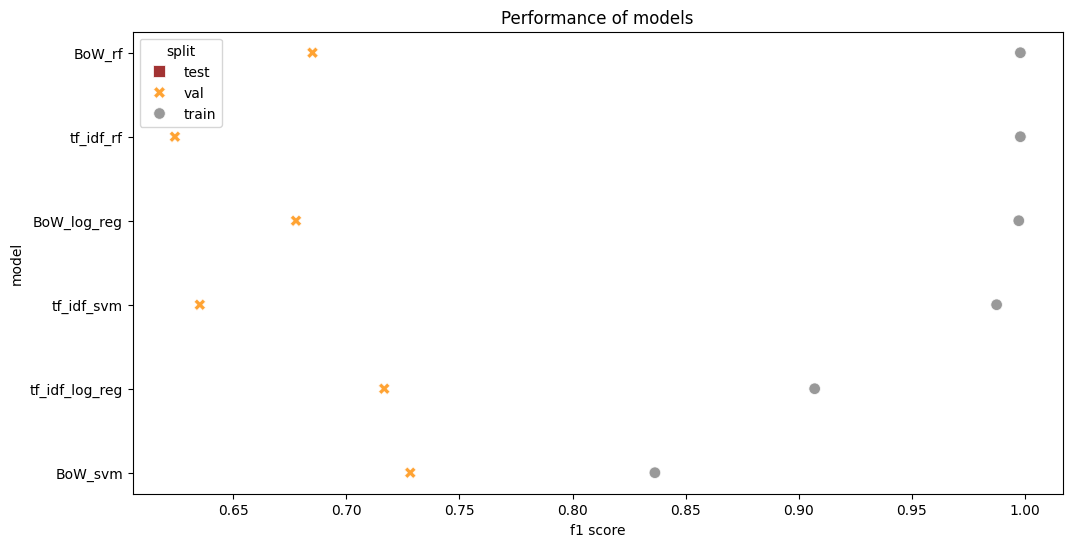

In [ ]:
# plotting performances
perf_df = pd.DataFrame(performances)

# specifying the order in splits to make the points more visible
order = ['test','val', 'train']
markers = {'test': 's', 'val': 'X', 'train': 'o'}

#plot
fig, ax = plt.subplots(figsize=(12, 6)) # make wider to show the points which are ontop of each other
sns.scatterplot(data=perf_df.sort_values(by='f1_score', ascending=False), 
                y='model', 
                x='f1_score', 
                style = 'split',
                hue='split', 
                markers = markers,
                palette=['darkred', 'darkorange','grey'],
                hue_order=order, 
                style_order=order, 
                s = 70,
                alpha = 0.8)
plt.title("Performance of models")
plt.xlabel("f1 score")
fig = plt.gcf() # get current figure
#plt.savefig('../figures/model_performance.jpeg', format='jpeg', dpi=300) 
plt.show()

In [180]:
performances

[{'model': 'BoW_log_reg',
  'split': 'train',
  'mean_acc_score': 0.9972,
  'f1_score': 0.9972},
 {'model': 'BoW_log_reg',
  'split': 'val',
  'mean_acc_score': 0.6742,
  'f1_score': 0.6778},
 {'model': 'BoW_rf',
  'split': 'train',
  'mean_acc_score': 0.9979,
  'f1_score': 0.9979},
 {'model': 'BoW_rf',
  'split': 'val',
  'mean_acc_score': 0.6798,
  'f1_score': 0.6851},
 {'model': 'BoW_svm',
  'split': 'train',
  'mean_acc_score': 0.8399,
  'f1_score': 0.8364},
 {'model': 'BoW_svm',
  'split': 'val',
  'mean_acc_score': 0.736,
  'f1_score': 0.7283},
 {'model': 'tf_idf_log_reg',
  'split': 'train',
  'mean_acc_score': 0.9094,
  'f1_score': 0.907},
 {'model': 'tf_idf_log_reg',
  'split': 'val',
  'mean_acc_score': 0.7247,
  'f1_score': 0.7168},
 {'model': 'tf_idf_rf',
  'split': 'train',
  'mean_acc_score': 0.9979,
  'f1_score': 0.9979},
 {'model': 'tf_idf_rf',
  'split': 'val',
  'mean_acc_score': 0.6348,
  'f1_score': 0.6243},
 {'model': 'tf_idf_svm',
  'split': 'train',
  'mean_acc_s

In [181]:
with open("model_performances.txt", "w") as output:
    output.write(str(performances))

## 3.3 DistilRoBerta 


In [2]:
!pip install evaluate
!pip install transformers
!pip install 'accelerate>=0.26.0'

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 71.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch
import evaluate
from transformers import pipeline
from transformers import Trainer, TrainingArguments

from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from datasets import Dataset, DatasetDict
from transformers import RobertaTokenizer

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import RobertaForSequenceClassification


In [4]:
# load data which has not been lowercased

train = pd.read_csv("../2_preprocessing/train_case_sensitive.csv")
val = pd.read_csv("../2_preprocessing/validation_case_sensitive.csv")
test = pd.read_csv("../2_preprocessing/test_case_sensitive.csv")

train.head()

,title,rating,imdbid,year,id,passed_bechdel,script_filename,script
0,&#39;Tamara Drewe&#39;,3,1486190,2010,2358,1,Tamara Drewe_1486190.txt,TAMARA DREWE Written by Moira Buffini Based on...
1,Julia,3,76245,1977,862,1,Julia_0076245.txt,w a FADE IN LONG SHOT A WOMAN LILLIAN 1962 DAY...
2,Terminator 2: Judgement Day,3,103064,1991,847,1,Terminator 2 Judgment Day_0103064.txt,TERMINATOR 2 JUDGEMENT DAY a Screenplay by Jam...
3,"Lost Weekend, The",2,37884,1945,3583,0,The Lost Weekend_0037884.txt,ÿþ
4,"Fog, The",3,80749,1980,2484,1,The Fog_0080749.txt,THE FOG a screenp lay by John Carpenter and De...


In [5]:
train = pd.read_csv("../2_preprocessing/train_lowercase.csv")
train.head()

,title,rating,imdbid,year,id,passed_bechdel,script_filename,script
0,&#39;Tamara Drewe&#39;,3,1486190,2010,2358,1,Tamara Drewe_1486190.txt,tamara drewe written by moira buffini based on...
1,Julia,3,76245,1977,862,1,Julia_0076245.txt,w a fade in long shot a woman lillian 1962 day...
2,Terminator 2: Judgement Day,3,103064,1991,847,1,Terminator 2 Judgment Day_0103064.txt,terminator 2 judgement day a screenplay by jam...
3,"Lost Weekend, The",2,37884,1945,3583,0,The Lost Weekend_0037884.txt,ÿþ
4,"Fog, The",3,80749,1980,2484,1,The Fog_0080749.txt,the fog a screenp lay by john carpenter and de...


In [8]:
train['script'][3]

'ÿþ'

In [208]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
data = DatasetDict({"train": train_dataset, "validation": val_dataset})

# Load DistilRoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["script"], padding="max_length", truncation=True)

tokenized_datasets = data.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["script"])  # Remove raw text after tokenization
tokenized_datasets = tokenized_datasets.rename_column("passed_bechdel", "labels")  # Rename for Trainer compatibility
tokenized_datasets.set_format("torch")  # Use PyTorch tensors

# Load DistilRoBERTa for Sequence Classification
model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)  # Adjust num_labels for your task

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",       # Evaluate at the end of each epoch
    save_strategy="epoch",             # Save checkpoint at each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,       # Load the best model based on validation accuracy
    metric_for_best_model="accuracy",  # Select best model based on validation accuracy
    save_total_limit=2                 # Save at most 2 checkpoints
)

# Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],  # Validation dataset for evaluation
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Explicitly evaluate the model on the validation dataset after training
validation_results = trainer.evaluate(eval_dataset=tokenized_datasets["validation"])
print("\nValidation Results After Training:")
print(validation_results)


Map:   0%|          | 0/1424 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ucloud/.local/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>={ACCELERATE_MIN_VERSION}'`

old code below

In [ ]:
model_name = 'distilroberta-base' # not sensitive to cases - and we made everything lower case!
tokenizer = AutoTokenizer.from_pretrained(model_name)
#tokenizer = DistilBertTokenizer.from_pretrained("distilroberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [188]:
# Tokenize the script column for each dataset
def tokenize_data(data, tokenizer, max_length=512):
    return tokenizer(
        list(data['script']),               # The text column to tokenize
        padding=True,                       # Pad shorter sequences - probably not necessary
        truncation=True,                    # Truncate longer sequences
        max_length=max_length,              # Maximum sequence length
        return_tensors="pt"                 # Return PyTorch tensors
    )

train_encodings = tokenize_data(train, tokenizer) # creates token IDs
val_encodings = tokenize_data(val, tokenizer)
test_encodings = tokenize_data(test, tokenizer)

# Convert labels to tensors
train_labels = torch.tensor(train['passed_bechdel'].values)
val_labels = torch.tensor(val['passed_bechdel'].values)
test_labels = torch.tensor(test['passed_bechdel'].values)


In [193]:
train_labels

tensor([1, 1, 1,  ..., 1, 0, 1])

In [ ]:

# Prepare dataset for PyTorch/TensorFlow
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove text column after tokenization
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")  # Rename label column for Trainer
tokenized_datasets.set_format("torch")  # Set format for PyTorch (use "tensorflow" for TF)

# Load the model
model = DistilBertForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)  # Change num_labels for multi-class tasks

# Define metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",          # Directory to save model checkpoints
    evaluation_strategy="epoch",    # Evaluate at the end of each epoch
    save_strategy="epoch",          # Save checkpoint at each epoch
    learning_rate=2e-5,             # Learning rate
    per_device_train_batch_size=16, # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    num_train_epochs=3,             # Number of epochs
    weight_decay=0.01,              # Weight decay
    logging_dir="./logs",           # Directory for logs
    load_best_model_at_end=True,    # Load the best model at the end
    metric_for_best_model="accuracy",
    save_total_limit=2              # Limit total saved checkpoints
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)


## 3.3 Distilbert 

In [ ]:
import torch
import evaluate
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification

In [ ]:
# tokenize the script

# Load the DistilBERT tokenizer
model_name = 'distilbert-base-uncased' # not sensitive to cases - and we made everything lower case!
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the script column for each dataset
def tokenize_data(data, tokenizer, max_length=512):
    return tokenizer(
        list(data['script']),               # The text column to tokenize
        padding=True,                       # Pad shorter sequences - probably not necessary
        truncation=True,                    # Truncate longer sequences
        max_length=max_length,              # Maximum sequence length
        return_tensors="pt"                 # Return PyTorch tensors
    )

train_encodings = tokenize_data(train_data, tokenizer) # creates token IDs
val_encodings = tokenize_data(val_data, tokenizer)
test_encodings = tokenize_data(test_data, tokenizer)

# Convert labels to tensors
train_labels = torch.tensor(train_data['passed_bechdel'].values)
val_labels = torch.tensor(val_data['passed_bechdel'].values)
test_labels = torch.tensor(test_data['passed_bechdel'].values)


In [18]:
# create dataset and dataloader

from torch.utils.data import Dataset, DataLoader

# Define a custom Dataset class
class MovieDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create Dataset objects
train_dataset = MovieDataset(train_encodings, train_labels)
val_dataset = MovieDataset(val_encodings, val_labels)
test_dataset = MovieDataset(test_encodings, test_labels)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [19]:
# define the model

from transformers import DistilBertForSequenceClassification

# Load the pre-trained DistilBERT model with a classification head
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [22]:
# train the model
from torch.optim import AdamW
from transformers import get_scheduler

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define a learning rate scheduler
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Define the loss function
from torch.nn import CrossEntropyLoss
loss_fn = CrossEntropyLoss()

# Training loop
from tqdm import tqdm

epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # Move batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        # Update progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
    
    print(f"Epoch {epoch} Loss: {total_loss / len(train_loader)}")


Epoch 0: 100%|██████████| 89/89 [00:28<00:00,  3.15it/s, loss=0.619]


Epoch 0 Loss: 0.6333726145578235


Epoch 1: 100%|██████████| 89/89 [00:28<00:00,  3.12it/s, loss=0.577]


Epoch 1 Loss: 0.5366610127888368


Epoch 2: 100%|██████████| 89/89 [00:28<00:00,  3.08it/s, loss=0.357]

Epoch 2 Loss: 0.4054129428408119


In [23]:
# evaluate the model
from sklearn.metrics import accuracy_score

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Move batch to the device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Get predictions
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=-1)
            
            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
    
    return accuracy_score(all_labels, all_preds)

# Evaluate on validation and test sets
val_accuracy = evaluate_model(model, val_loader)
print(f"Validation Accuracy: {val_accuracy}")

test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy}")


Validation Accuracy: 0.6348314606741573
Test Accuracy: 0.7318435754189944


In [24]:
# save the model
model.save_pretrained("distilbert_bechdel_classifier")
tokenizer.save_pretrained("distilbert_bechdel_classifier")


('distilbert_bechdel_classifier/tokenizer_config.json',
 'distilbert_bechdel_classifier/special_tokens_map.json',
 'distilbert_bechdel_classifier/vocab.txt',
 'distilbert_bechdel_classifier/added_tokens.json',
 'distilbert_bechdel_classifier/tokenizer.json')